# Attenuation correction comparison with wradlib

Comparison between BALTRAD and wradlib attenuation correction

## Retrieve data from s3 bucket

In [1]:
import os
import urllib.request
from pathlib import Path

# Set the URL for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = "pythia/radar/erad2024/baltrad/baltrad2wradlib/"
!mkdir -p data
!mkdir -p shp
files = [
    "data/201405190715_SUR.h5",
    "shp/europe_countries.dbf",
    "shp/europe_countries.prj",
    "shp/europe_countries.sbn",
    "shp/europe_countries.sbx",
    "shp/europe_countries.shp",
    "shp/europe_countries.shx",
]
for file in files:
    file0 = os.path.join(path, Path(file).name)
    if not os.path.exists(file):
        print(f"downloading, {file}")
        x = urllib.request.urlretrieve(f"{URL}{file0}", file)

downloading, data/201405190715_SUR.h5


downloading, shp/europe_countries.dbf
downloading, shp/europe_countries.prj


downloading, shp/europe_countries.sbn
downloading, shp/europe_countries.sbx


downloading, shp/europe_countries.shp


downloading, shp/europe_countries.shx


## Prepare your environment

In [2]:
%matplotlib inline

In [3]:
import gc

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import shapefile
import wradlib
import xradar as xd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

## Run BALTRAD's odc_toolbox

First, you will process a scan from Suergavere (Estland) by using BALTRAD's odc_toolbox.

From your VM's vagrant directory, navigate to the folder ``/baltrad2wradlib``.

Execute the following command:

``$ odc_toolbox -i data -o out -q ropo,radvol-att``

Check whether a file was created in the folder ``/out``.

**BALTRAD will not create output files if these already exist.** You can check that via ``!ls out``.

In [4]:
!odc_toolbox --help

Usage: odc_toolbox -i <inpath> -o <outpath> -q <algorithm-list> [-p <processes>] [h]

Command-line tool for QC-processing polar data for Odyssey

Options:
  -h, --help            show this help message and exit
  -i IPATH, --ipath=IPATH
                        Input path containing polar data.
  -o OPATH, --opath=OPATH
                        Output path for writing data.
  -q QC, --qc=QC        Comma-separated list of which QC algorithms to run,
                        e.g. 'ropo,beamb'. No white spaces between these
                        names. For compositing, this executable hard-wires a
                        quality-based composite algorithm where the last QC
                        algorithm in the chain should be qi-total.
  -d, --delete          Deletes input files following their processing.
  -c, --check           Checks for the presence of output files. If an output
                        file already exists, do nothing and move on to the
                        next.
 

In [5]:
!odc_toolbox -i data -o out -q ropo,radvol-att

Exception ignored in: <function _after_at_fork_child_reinit_locks at 0x7efe8aff1800>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/__init__.py", line 265, in _after_at_fork_child_reinit_locks
Exception ignored in: <function _after_at_fork_child_reinit_locks at 0x7efe8aff1800>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/logging/__init__.py", line 265, in _after_at_fork_child_reinit_locks
    handler._at_fork_reinit()
  File "/srv/conda/envs/notebook/lib/python3.11/logging/__init__.py", line 920, in _at_fork_reinit
    handler._at_fork_reinit()
  File "/srv/conda/envs/notebook/lib/python3.11/logging/__init__.py", line 920, in _at_fork_reinit
        self.lock._at_fork_reinit()
    ^self.lock._at_fork_reinit()
^^  ^^^^^^  ^^^^^^^^^^^^^^^^^
AttributeError: 'RLock' object has no attribute '_at_fork_reinit'
^^^^^^^^^^^^^Exception ignored in: ^^^<function _after_at_fork_child_reinit_locks at 0x7efe8aff1800>
Tr

In [6]:
!ls out

201405190715_SUR.h5


## Read and inspect data from Suergavere (Estonia) before and after QC with odc_toolbox

In [7]:
# Before QC
inp = xd.io.open_odim_datatree("data/201405190715_SUR.h5")
# After QC
out = xd.io.open_odim_datatree("out/201405190715_SUR.h5")

## Georeference

In [8]:
inp = inp.xradar.georeference()
out = out.xradar.georeference()

In [9]:
swp_inp = inp["sweep_0"].ds.set_coords("sweep_mode")
swp_out = out["sweep_0"].ds.set_coords("sweep_mode")
display(swp_inp)
display(swp_out)

<xarray.Dataset> Size: 26MB
Dimensions:            (azimuth: 360, range: 831)
Coordinates:
    elevation          (azimuth) float32 1kB 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    time               (azimuth) datetime64[ns] 3kB 2014-05-19T07:15:22.33890...
  * range              (range) float32 3kB 1.05e+03 1.35e+03 ... 2.5e+05
    sweep_mode         <U20 80B ...
    longitude          float64 8B 25.52
    latitude           float64 8B 58.48
    altitude           float64 8B 157.0
  * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float32 1MB 9.162 11.78 ... -2.181e+03
    y                  (azimuth, range) float32 1MB 1.05e+03 ... 2.499e+05
    z                  (azimuth, range) float32 1MB 167.0 169.0 ... 6.022e+03
Data variables: (12/14)
    DBZH               (azimuth, range) float64 2MB ...
    VRAD               (azimuth, range) float64 2MB ...
    RHOHV              (azimuth, range) float64 2MB ...
    HCLASS             (azimuth, range) float32 1MB ...
    PHIDP              (azimuth, range) float64 2MB ...
    ZDR                (azimuth, range) float64 2MB ...
    ...                 ...
    TH                 (azimuth, range) float64 2MB ...
    WRAD               (azimuth, range) float64 2MB ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...

<xarray.Dataset> Size: 31MB
Dimensions:            (azimuth: 360, range: 831)
Coordinates:
    elevation          (azimuth) float32 1kB 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    time               (azimuth) datetime64[ns] 3kB 2014-05-19T07:15:22.33890...
  * range              (range) float32 3kB 1.05e+03 1.35e+03 ... 2.5e+05
    sweep_mode         <U20 80B ...
    longitude          float64 8B 25.52
    latitude           float64 8B 58.48
    altitude           float64 8B 157.0
  * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
    crs_wkt            int64 8B 0
    x                  (azimuth, range) float32 1MB 9.162 11.78 ... -2.181e+03
    y                  (azimuth, range) float32 1MB 1.05e+03 ... 2.499e+05
    z                  (azimuth, range) float32 1MB 167.0 169.0 ... 6.022e+03
Data variables: (12/16)
    DBZH               (azimuth, range) float64 2MB ...
    TH                 (azimuth, range) float64 2MB ...
    RHOHV              (azimuth, range) float64 2MB ...
    HCLASS             (azimuth, range) float32 1MB ...
    WRADH              (azimuth, range) float64 2MB ...
    PHIDP              (azimuth, range) float64 2MB ...
    ...                 ...
    quality1           (azimuth, range) float64 2MB ...
    QIND               (azimuth, range) float64 2MB ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...

## Design a plot we will use for all PPIs in this exercise

In [10]:
import cartopy.crs as ccrs
import wradlib as wrl
from cartopy.io.shapereader import Reader

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=swp_inp.latitude.values, central_longitude=swp_inp.longitude.values
)
osr_proj = wrl.georef.create_osr(
    "aeqd", lat_0=swp_inp.latitude.values, lon_0=swp_inp.longitude.values
)

geometries = list(Reader("shp/europe_countries.shp").geometries())


def plot_ppi_to_ax(ppi, ax, title="", geometries=None, **kwargs):
    pm = ppi.wrl.vis.plot(crs=map_proj, ax=ax, **kwargs)
    ax.set_title(title)
    if geometries is not None:
        ax.add_geometries(
            geometries,
            ccrs.PlateCarree(),
            facecolor="lightgrey",
            edgecolor="k",
            linewidths=1,
            zorder=-1,
        )
    wrl.vis.plot_ppi_crosshair(
        site=(ppi.longitude.values, ppi.latitude.values, ppi.altitude.values),
        ranges=[50000, 100000, 150000, 200000, ppi.range.max().values],
        angles=[0, 90, 180, 270],
        line=dict(color="white"),
        circle={"edgecolor": "white"},
        ax=ax,
        crs=osr_proj,
    )
    return pm

## Plot the selected fields into one figure

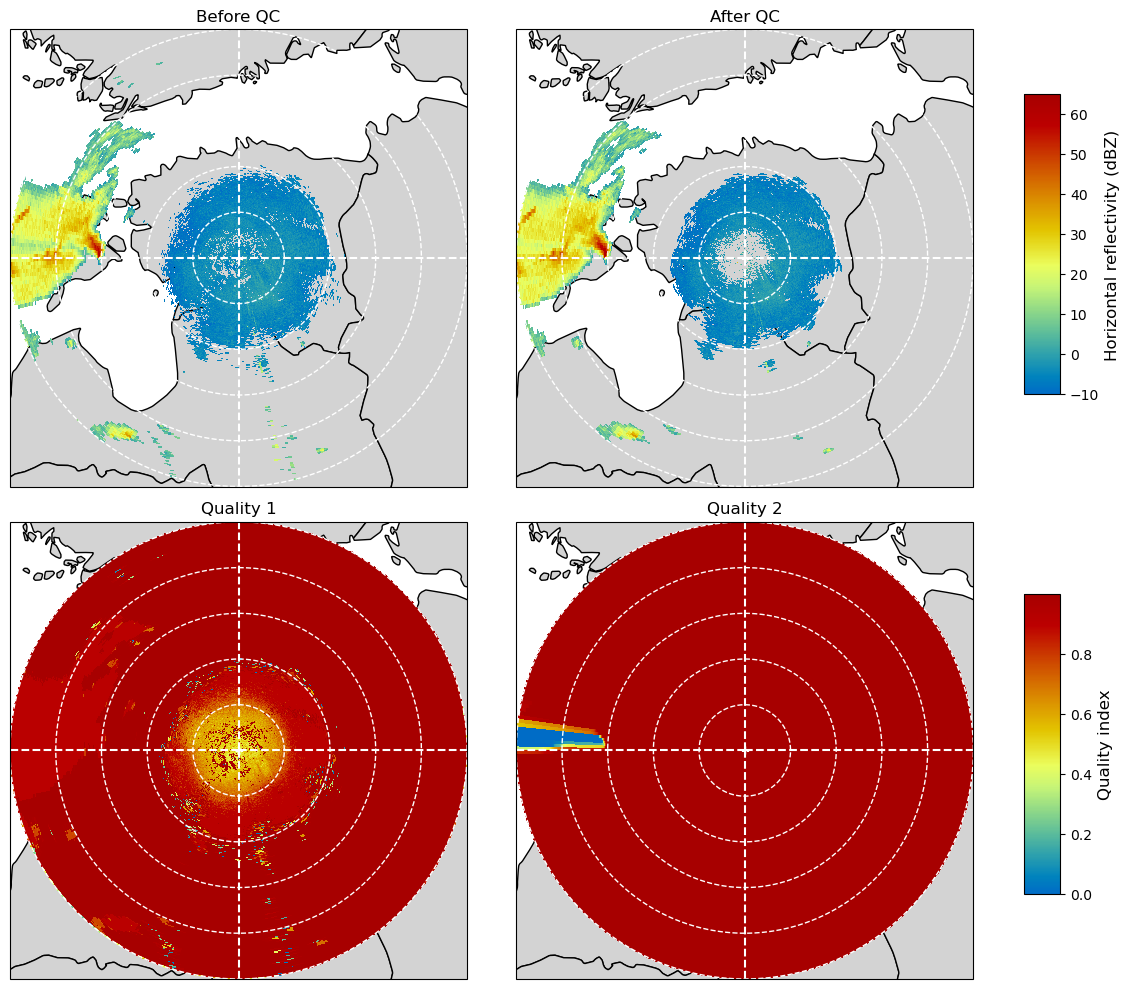

In [11]:
fig = plt.figure(figsize=(12, 10))

ax = plt.subplot(221, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_inp.DBZH.where(swp_inp.DBZH >= -10),
    ax=ax,
    geometries=geometries,
    title="Before QC",
    add_colorbar=False,
    vmin=-10,
    vmax=65,
)

ax = plt.subplot(222, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_out.DBZH.where(swp_out.DBZH >= -10),
    ax=ax,
    geometries=geometries,
    title="After QC",
    add_colorbar=False,
    vmin=-10,
    vmax=65,
)

ax = plt.subplot(223, projection=map_proj)
qm = plot_ppi_to_ax(
    swp_out.quality1,
    ax=ax,
    geometries=geometries,
    add_colorbar=False,
    title="Quality 1",
)

ax = plt.subplot(224, projection=map_proj)
qm = plot_ppi_to_ax(
    swp_out.QIND, ax=ax, geometries=geometries, add_colorbar=False, title="Quality 2"
)

plt.tight_layout()

# Add colorbars
fig.subplots_adjust(right=0.9)
cax = fig.add_axes((0.9, 0.6, 0.03, 0.3))
cbar = plt.colorbar(pm, cax=cax)
cbar.set_label("Horizontal reflectivity (dBZ)", fontsize="large")

cax = fig.add_axes((0.9, 0.1, 0.03, 0.3))
cbar = plt.colorbar(qm, cax=cax)
cbar.set_label("Quality index", fontsize="large")

## Collect and plot the polarimetric moments from the original ODIM_H5 dataset

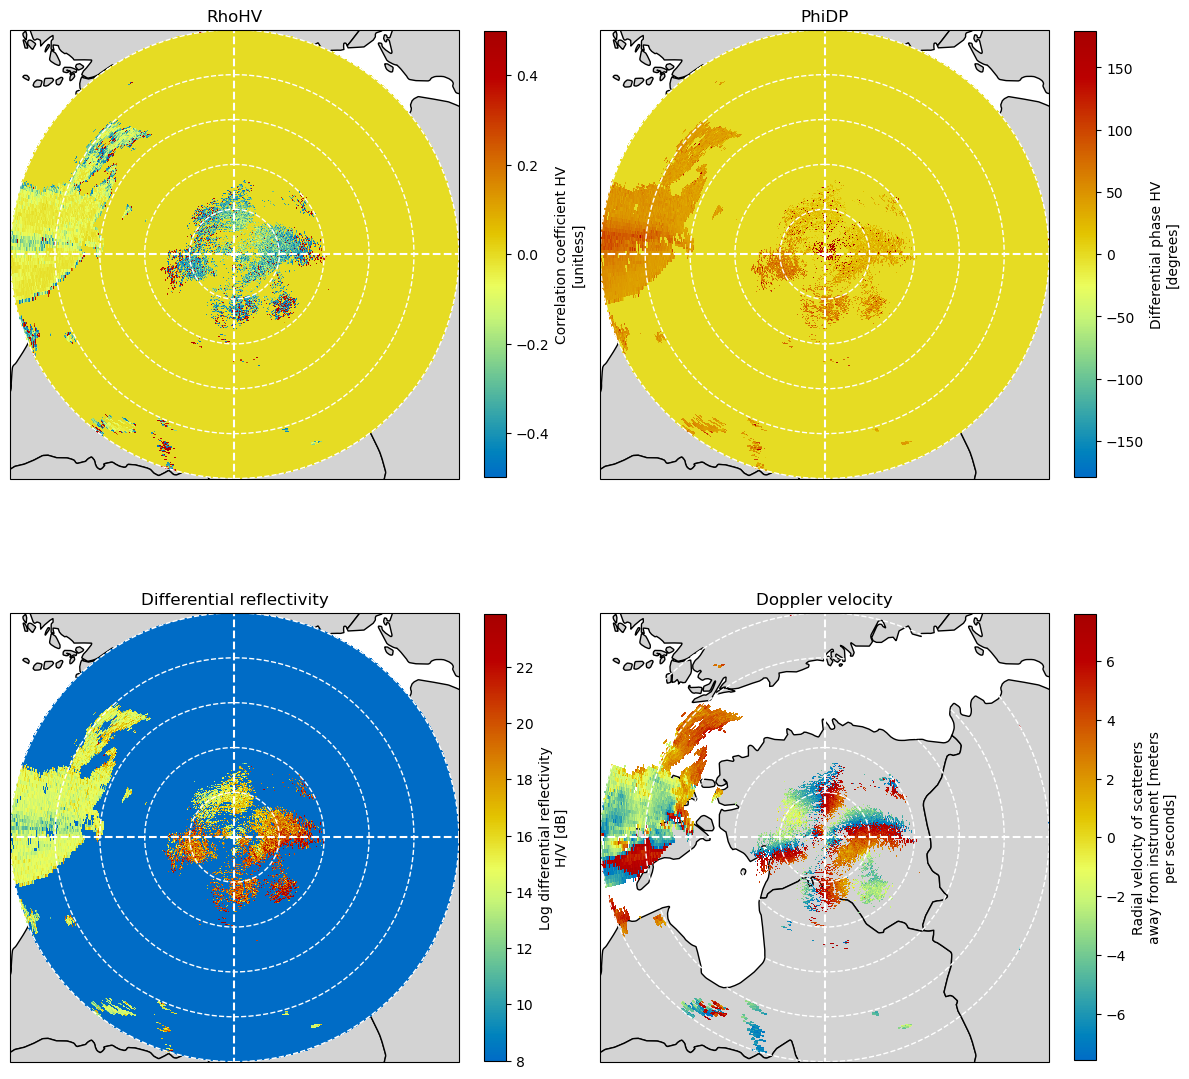

In [12]:
fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(221, projection=map_proj)
pm = plot_ppi_to_ax(swp_inp.RHOHV, ax=ax, title="RhoHV", geometries=geometries)

ax = plt.subplot(222, projection=map_proj)
pm = plot_ppi_to_ax(swp_inp.PHIDP, ax=ax, title="PhiDP", geometries=geometries)

ax = plt.subplot(223, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_inp.ZDR, ax=ax, title="Differential reflectivity", geometries=geometries
)

ax = plt.subplot(224, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_inp.VRAD, ax=ax, title="Doppler velocity", geometries=geometries
)

plt.tight_layout()

## Try some filtering and attenuation correction

In [13]:
# Set ZH to a very low value where we do not expect valid data
zh = swp_inp.DBZH.fillna(-32.0)
# Retrieve PIA by using some constraints (see https://docs.wradlib.org/en/latest/notebooks/attenuation/attenuation.html for help)
pia = zh.wrl.atten.correct_attenuation_constrained(
    constraints=[wradlib.atten.constraint_dbz, wradlib.atten.constraint_pia],
    constraint_args=[[64.0], [20.0]],
)

# Correct reflectivity by PIA
zh_corrected = swp_inp.DBZH + pia

/srv/conda/envs/notebook/lib/python3.11/site-packages/wradlib/trafo.py:339: RuntimeWarning: overflow encountered in power
  return 10.0 ** (x / 10.0)


## Compare results against QC from odc_toolbox

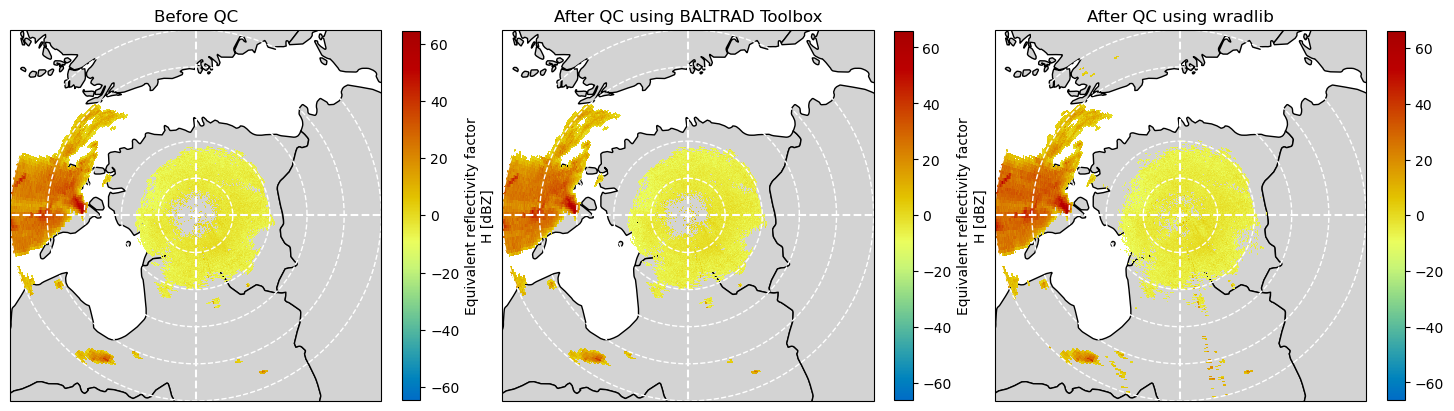

In [14]:
fig = plt.figure(figsize=(18, 10))

ax = plt.subplot(131, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_inp.DBZH.where(swp_out.DBZH >= -10),
    ax=ax,
    geometries=geometries,
    title="Before QC",
)

ax = plt.subplot(132, projection=map_proj)
pm = plot_ppi_to_ax(
    swp_out.DBZH.where(swp_out.DBZH >= -10),
    ax=ax,
    geometries=geometries,
    title="After QC using BALTRAD Toolbox",
)

ax = plt.subplot(133, projection=map_proj)
pm = plot_ppi_to_ax(
    zh_corrected.where(zh_corrected >= -10),
    ax=ax,
    geometries=geometries,
    title="After QC using wradlib",
)